# Trabajo Práctico: Exploración y Preparación de Airbnb Listings


## Objetivo
En esta libreta analizamos el dataset `listings_big.csv` para comprender su estructura, diagnosticar problemas de calidad y preparar un conjunto de features apto para estimar **qué tan alquilable es un listing**. El flujo general incluye:
- Exploración inicial y resumen estadístico
- Análisis de valores faltantes y patrones de disponibilidad
- Visualizaciones que permitan interpretar la ocupación y sus drivers
- Definición de un problema supervisado de clasificación enfocado en la alta ocupación
- Construcción de un pipeline de preprocesamiento, ingeniería de variables y selección/reducción de dimensionalidad


# 🏡 Airbnb Listings Data Dictionary

> Diccionario de datos del conjunto de listados de Airbnb, con tipos de datos, campos calculados y descripciones.  
> Compatible con visualización en GitHub (scroll horizontal automático en tablas grandes).

---

<div style="overflow-x: auto;">

| **Field** | **Type** | **Calculated** | **Description** |
|------------|-----------|----------------|-----------------|
| id | integer |  | Airbnb's unique identifier for the listing |
| listing_url | text | ✅ |  |
| scrape_id | bigint | ✅ | Inside Airbnb "Scrape" this was part of |
| last_scraped | datetime | ✅ | UTC. The date and time this listing was "scraped". |
| source | text |  | One of `"neighbourhood search"` or `"previous scrape"`. Describes how the listing was discovered. |
| name | text |  | Name of the listing |
| description | text |  | Detailed description of the listing |
| neighborhood_overview | text |  | Host's description of the neighbourhood |
| picture_url | text |  | URL to Airbnb-hosted regular-sized image |
| host_id | integer |  | Airbnb's unique identifier for the host/user |
| host_url | text | ✅ | Airbnb page for the host |
| host_name | text |  | Name of the host (usually first name). |
| host_since | date |  | Host account creation date |
| host_location | text |  | Host's self-reported location |
| host_about | text |  | Description about the host |
| host_response_time | text |  |  |
| host_response_rate | text |  |  |
| host_acceptance_rate | text |  | Rate at which host accepts booking requests |
| host_is_superhost | boolean *(t=true; f=false)* |  |  |
| host_thumbnail_url | text |  |  |
| host_picture_url | text |  |  |
| host_neighbourhood | text |  |  |
| host_listings_count | text |  | Number of listings (Airbnb internal) |
| host_total_listings_count | text |  | Total listings (Airbnb internal) |
| host_verifications | text |  |  |
| host_has_profile_pic | boolean *(t=true; f=false)* |  |  |
| host_identity_verified | boolean *(t=true; f=false)* |  |  |
| neighbourhood | text |  |  |
| neighbourhood_cleansed | text | ✅ | Geocoded neighbourhood (from shapefiles) |
| neighbourhood_group_cleansed | text | ✅ | Geocoded neighbourhood group (from shapefiles) |
| latitude | numeric |  | WGS84 latitude |
| longitude | numeric |  | WGS84 longitude |
| property_type | text |  | Self-selected property type |
| room_type | text |  | One of:<br>• **Entire home/apt** — Whole space<br>• **Private room** — Own room, shared areas<br>• **Shared room** — Shared sleeping space |
| accommodates | integer |  | Max guest capacity |
| bathrooms | numeric |  | Number of bathrooms |
| bathrooms_text | string |  | Text description of bathrooms (legacy field) |
| bedrooms | integer |  | Number of bedrooms |
| beds | integer |  | Number of beds |
| amenities | json |  | JSON array of amenities |
| price | currency |  | Daily price (ignore `$` artifact) |
| minimum_nights | integer |  | Minimum nights allowed |
| maximum_nights | integer |  | Maximum nights allowed |
| minimum_minimum_nights | integer | ✅ | Smallest min nights (calendar, 365 days ahead) |
| maximum_minimum_nights | integer | ✅ | Largest min nights (calendar, 365 days ahead) |
| minimum_maximum_nights | integer | ✅ | Smallest max nights (calendar, 365 days ahead) |
| maximum_maximum_nights | integer | ✅ | Largest max nights (calendar, 365 days ahead) |
| minimum_nights_avg_ntm | numeric | ✅ | Avg min nights (calendar, 365 days ahead) |
| maximum_nights_avg_ntm | numeric | ✅ | Avg max nights (calendar, 365 days ahead) |
| calendar_updated | date |  |  |
| has_availability | boolean |  | *(t=true; f=false)* |
| availability_30 | integer | ✅ | Available nights (next 30 days) |
| availability_60 | integer | ✅ | Available nights (next 60 days) |
| availability_90 | integer | ✅ | Available nights (next 90 days) |
| availability_365 | integer | ✅ | Available nights (next 365 days) |
| calendar_last_scraped | date |  |  |
| number_of_reviews | integer |  | Total number of reviews |
| number_of_reviews_ltm | integer | ✅ | Reviews in last 12 months |
| number_of_reviews_l30d | integer | ✅ | Reviews in last 30 days |
| first_review | date | ✅ | Date of first review |
| last_review | date | ✅ | Date of most recent review |
| review_scores_rating | numeric |  |  |
| review_scores_accuracy | numeric |  |  |
| review_scores_cleanliness | numeric |  |  |
| review_scores_checkin | numeric |  |  |
| review_scores_communication | numeric |  |  |
| review_scores_location | numeric |  |  |
| review_scores_value | numeric |  |  |
| license | text |  | Licence/permit/registration number |
| instant_bookable | boolean |  | *(t=true; f=false)* — Guests can book instantly |
| calculated_host_listings_count | integer | ✅ | Number of listings host has in this scrape (city/region) |
| calculated_host_listings_count_entire_homes | integer | ✅ | Entire homes owned by host |
| calculated_host_listings_count_private_rooms | integer | ✅ | Private rooms owned by host |
| calculated_host_listings_count_shared_rooms | integer | ✅ | Shared rooms owned by host |
| reviews_per_month | numeric | ✅ | Average reviews per month over listing lifetime.<br><br>**Pseudocode/SQL:**<br>`IF scrape_date - first_review <= 30 THEN number_of_reviews`<br>`ELSE number_of_reviews / ((scrape_date - first_review + 1) / (365/12))` |

</div>

---

✅ = Calculated field  
📘 *Boolean values*: `t=true`, `f=false`  
🌐 *Coordinates*: WGS84 projection  
💡 *Source*: [Inside Airbnb](http://insideairbnb.com/)


In [541]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import ast
import re

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (8, 5)
pd.set_option('display.max_columns', 80)
pd.set_option("display.float_format", "{:.4f}".format)

DATA_PATH = Path('listings_big.csv')


In [542]:
df_raw = pd.read_csv(
    DATA_PATH,
    na_values=("N/A", "NA", "na", "n/a", "", "-", ".","nan"),
    keep_default_na=True
)

df = df_raw.copy()
# Limpieza de precios: eliminar símbolos y convertir a numérico
df['price'] = (df['price']
               .astype(str)
               .str.replace(r'[€$£,]', '', regex=True)
               .str.strip())

df['price'] = pd.to_numeric(df['price'], errors='coerce')

# Conversión de columnas fecha para posteriores features
date_columns = ['last_scraped', 'host_since', 'first_review', 'last_review']

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

df['host_id'] = df['host_id'].astype('string')

print(f"Shape original: {df_raw.shape}")
print(f"Shape después de transformaciones básicas: {df.shape}")


Shape original: (35172, 79)
Shape después de transformaciones básicas: (35172, 79)


## 1. Carga y saneamiento inicial


### 1.0 Limpieza y escalado del precio

Diagnosticamos si existen precios en cero/negativos, los imputamos con la mediana positiva y preparamos una versión escalada (`price_imputed`) compatible con MinMaxScaler para usar en el pipeline.


In [543]:
# # Diagnóstico y corrección de precios no positivos
# price_zero_count = (df['price'] == 0).sum()
# price_negative_count = (df['price'] < 0).sum()
# price_null_count = df['price'].isna().sum()
#
# print(f'Precios iguales a 0: {price_zero_count}')
# print(f'Precios negativos: {price_negative_count}')
# print(f'Precios nulos: {price_null_count}')
#
# positive_prices = df.loc[df['price'] > 0, 'price']
# if positive_prices.empty:
#     raise ValueError('No hay precios positivos disponibles para imputar.')
# median_positive_price = positive_prices.median()
# non_positive_mask = df['price'].le(0) | df['price'].isna()
#
# if non_positive_mask.any():
#     print(f"Imputando precios no positivos con la mediana de valores positivos: {median_positive_price:.2f}")
#
# df['price_imputed'] = df['price'].mask(non_positive_mask, median_positive_price)
# print(f"Precio mínimo tras imputación: {df['price_imputed'].min():.2f}")


In [544]:
# # Verificamos el rango tras aplicar MinMaxScaler sobre el precio imputado
# from sklearn.preprocessing import MinMaxScaler
# price_scaler = MinMaxScaler()
# price_scaled_preview = price_scaler.fit_transform(df[['price_imputed']])
#
# print(f"Rango del precio escalado: min={price_scaled_preview.min():.3f}, max={price_scaled_preview.max():.3f}")


### 1.0 Información general del dataset


In [545]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35172 entries, 0 to 35171
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            35172 non-null  int64         
 1   listing_url                                   35172 non-null  object        
 2   scrape_id                                     35172 non-null  int64         
 3   last_scraped                                  35172 non-null  datetime64[ns]
 4   source                                        35172 non-null  object        
 5   name                                          35172 non-null  object        
 6   description                                   34294 non-null  object        
 7   neighborhood_overview                         16585 non-null  object        
 8   picture_url                                   35171 non-null  obje

In [546]:
# Resumen de tipos de columnas y conteo por tipo
type_summary = df.dtypes.value_counts().rename('count').to_frame()
type_summary


,count
object,30
int64,23
float64,21
datetime64[ns],4
string[python],1


In [547]:
# Estadísticas descriptivas de variables numéricas
def format_numeric_summary(full_df, exclude_patterns=("id",), currency_cols=None, decimals=4):
    # excluir columnas que no tienen sentido estadístico
    columns_to_exclude = [c for c in full_df.columns if any(pat in c.lower() for pat in exclude_patterns)]
    summary_num = (
        full_df.drop(columns=columns_to_exclude)
          .select_dtypes(include="number")
          .describe()
          .T
          .round(decimals)
    )

    # versión formateada
    summary_fmt = summary_num.copy().astype(object)

    # aplicar formato a las currency_cols
    if currency_cols:
        for col in currency_cols:
            if col in summary_fmt.index:
                summary_fmt.loc[col] = summary_num.loc[col].apply(lambda x: f"${x:,.{decimals}f}")

    return summary_num, summary_fmt

columns_to_exclude = ["id", "scrape_id", "host_id", "calendar_updated","neighbourhood_group_cleansed"]
currency_cols = ["price", "estimated_revenue_l365d"]

numeric_summary, numeric_summary_fmt = format_numeric_summary(
    df.copy(),
    exclude_patterns=columns_to_exclude,
    currency_cols=currency_cols,
    decimals=2
)

numeric_summary


,count,mean,std,min,25%,50%,75%,max
host_listings_count,35166.0000,19.5400,41.2900,1.0000,1.0000,3.0000,16.0000,670.0000
host_total_listings_count,35166.0000,29.4300,79.5800,1.0000,1.0000,4.0000,20.0000,2542.0000
latitude,35172.0000,-34.5900,0.0200,-34.6900,-34.6000,-34.5900,-34.5800,-34.5300
longitude,35172.0000,-58.4200,0.0300,-58.5300,-58.4400,-58.4200,-58.3900,-58.3600
accommodates,35172.0000,2.9400,1.5500,1.0000,2.0000,2.0000,4.0000,16.0000
bathrooms,31602.0000,1.2400,0.6600,0.0000,1.0000,1.0000,1.0000,22.0000
bedrooms,34445.0000,1.1900,0.9400,0.0000,1.0000,1.0000,1.0000,35.0000
beds,31604.0000,1.9100,1.6000,0.0000,1.0000,1.0000,2.0000,36.0000
price,31598.0000,95487.7600,1402656.4200,260.0000,29711.0000,39908.0000,57762.0000,105021704.0000
minimum_nights,35172.0000,6.1600,26.0700,1.0000,1.0000,2.0000,4.0000,1000.0000


In [548]:
# Estadísticas básicas de variables categóricas/cadenas
categorical_cols = df.select_dtypes(include=['object', 'string']).columns
categorical_summary = df[categorical_cols].describe().T
categorical_summary_sorted = categorical_summary.sort_values("freq", ascending=False)

categorical_summary_sorted.head(80)


,count,unique,top,freq
host_identity_verified,35166,2,t,34159
has_availability,34005,2,t,33940
host_has_profile_pic,35166,2,t,33717
room_type,35172,4,Entire home/apt,32083
source,35172,2,city scrape,31613
host_verifications,35166,7,"['email', 'phone']",28522
calendar_last_scraped,35172,4,2025-01-30,26254
property_type,35172,66,Entire rental unit,25470
bathrooms_text,35148,48,1 bath,25236
instant_bookable,35172,2,f,24046


In [549]:
duplicate_count = df.duplicated(subset=['id']).sum()
print(f"Duplicados basados en 'id': {duplicate_count}")

missing_ids = df['id'].isna().sum()
print(f"IDs faltantes: {missing_ids}")


Duplicados basados en 'id': 0
IDs faltantes: 0


## 2. Valores faltantes



### 1.2 Exploración de duplicados y consistencia


In [550]:
missing_abs = df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct*100})
missing_table[missing_table["missing"]>0].head(55)


,missing,percent
neighbourhood_group_cleansed,35172,100.0000
calendar_updated,35172,100.0000
license,34783,98.8900
neighborhood_overview,18587,52.8500
neighbourhood,18584,52.8400
host_about,16360,46.5100
host_neighbourhood,13451,38.2400
host_location,7553,21.4700
review_scores_value,5761,16.3800
review_scores_accuracy,5761,16.3800


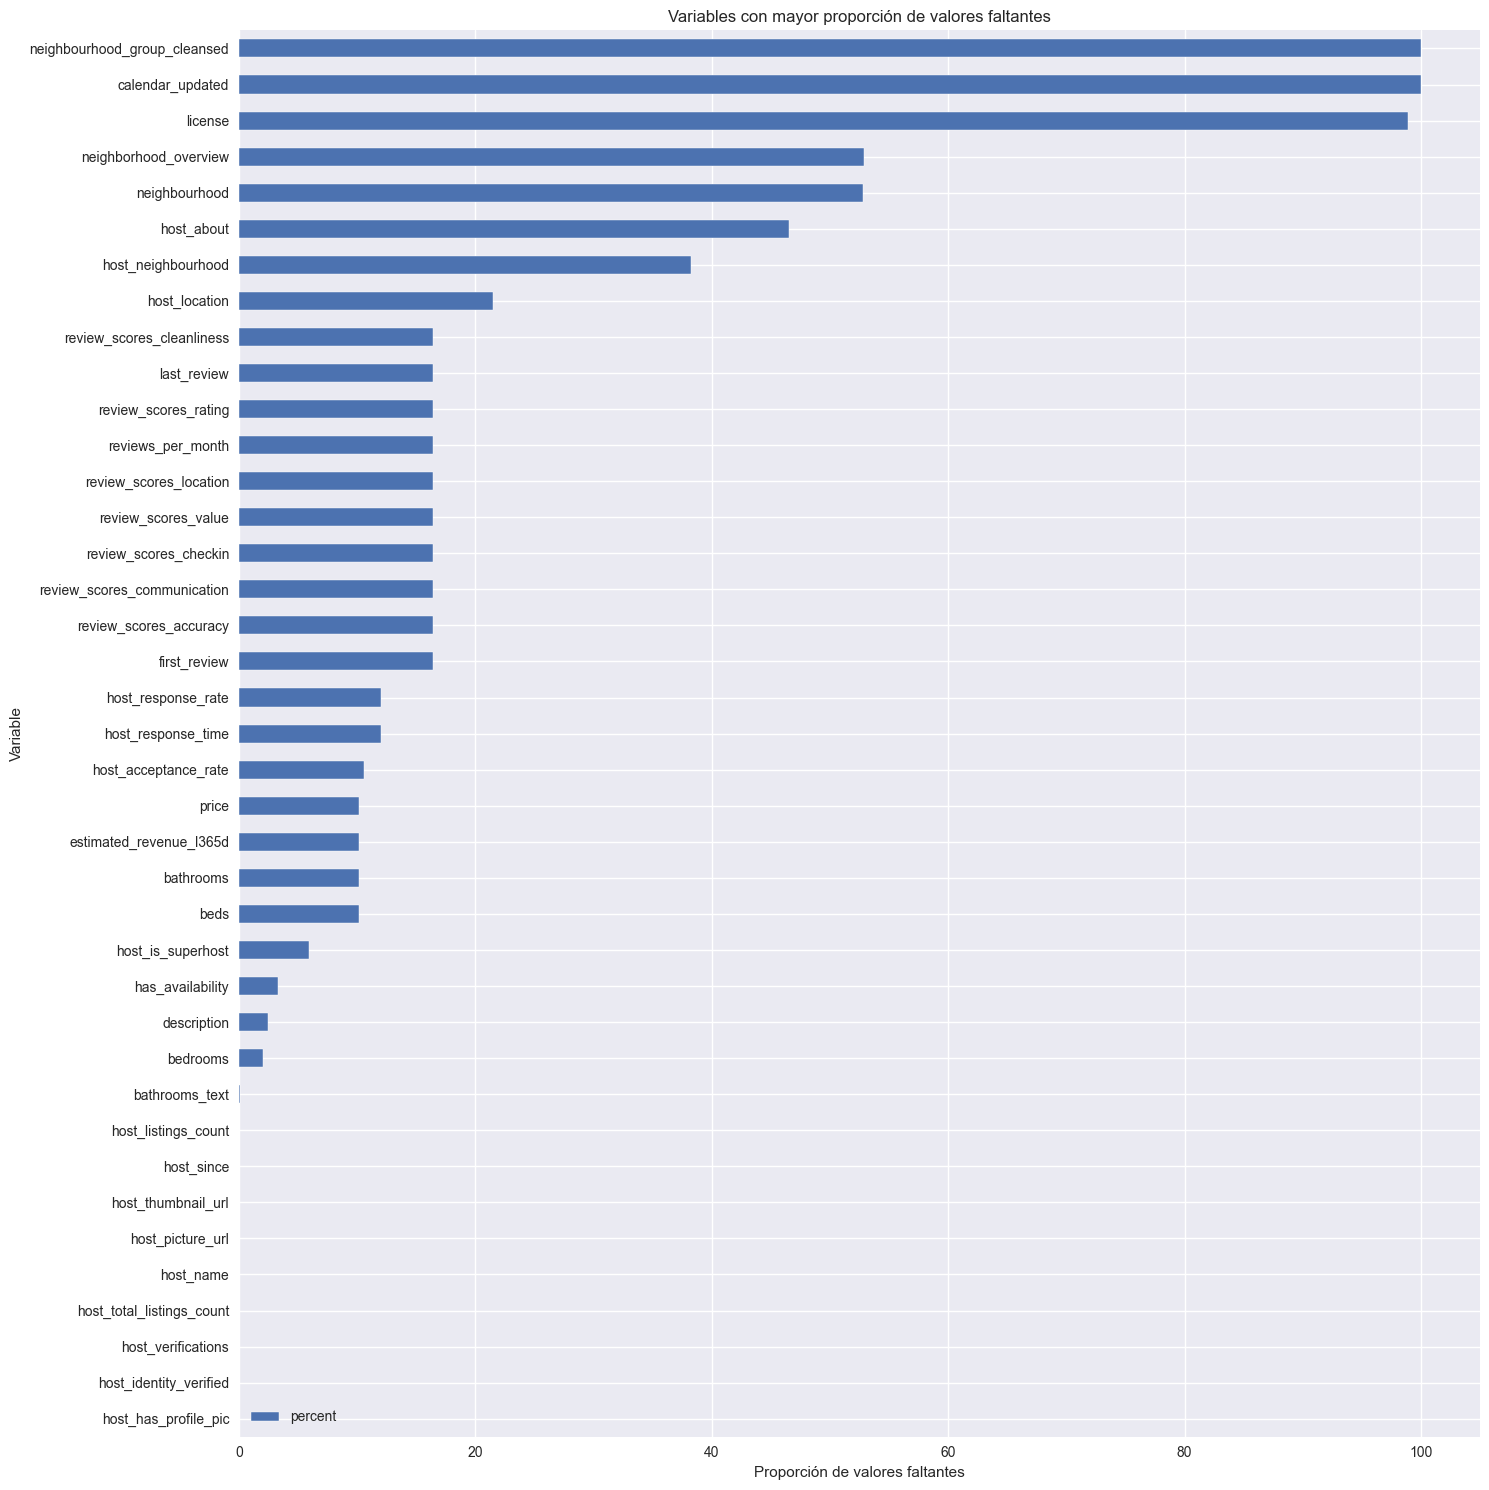

In [551]:
# Visualización del top de variables con mayor porcentaje de faltantes
top_missing = missing_table[missing_table['percent'] > 0].head(79)
ax = top_missing.sort_values('percent').plot.barh(y='percent', figsize=(15, 15))
ax.set_xlabel('Proporción de valores faltantes')
ax.set_ylabel('Variable')
ax.set_title('Variables con mayor proporción de valores faltantes')
plt.tight_layout()
plt.show()


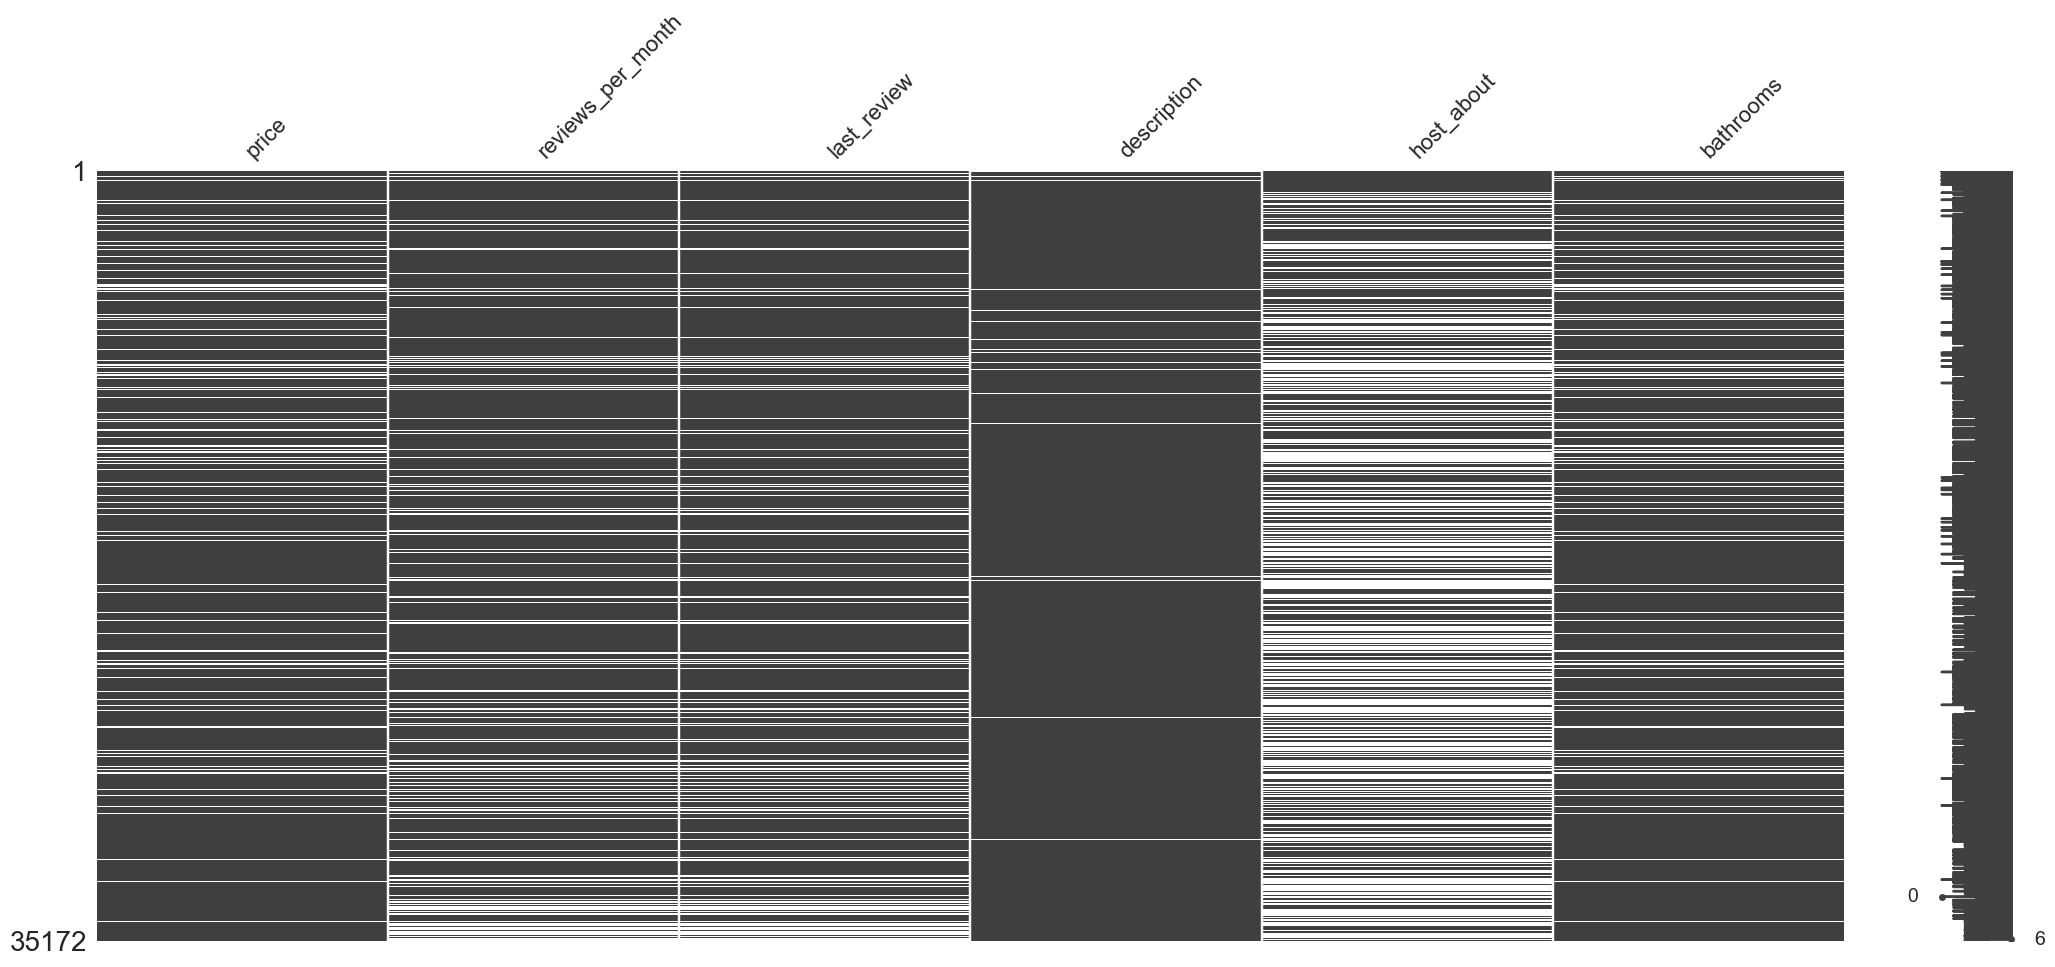

In [552]:
# Matriz de missingness para detectar patrones
try:
    import missingno as msno
    msno.matrix(df[['price', 'reviews_per_month', 'last_review', 'description', 'host_about', 'bathrooms']])
    plt.show()
except ImportError:
    print('missingno no está disponible en el entorno actual.')


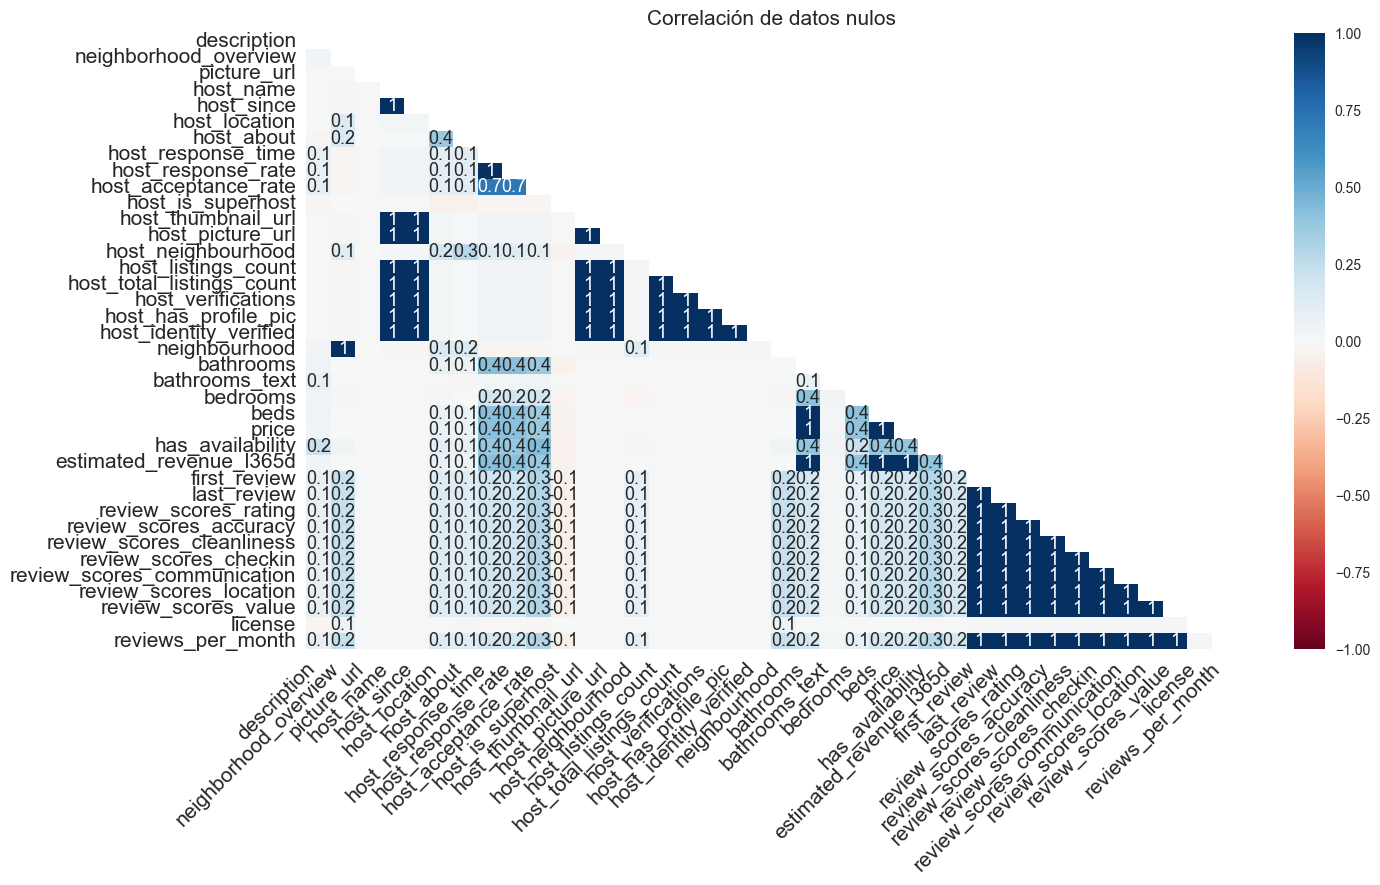

In [553]:
msno.heatmap(df, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

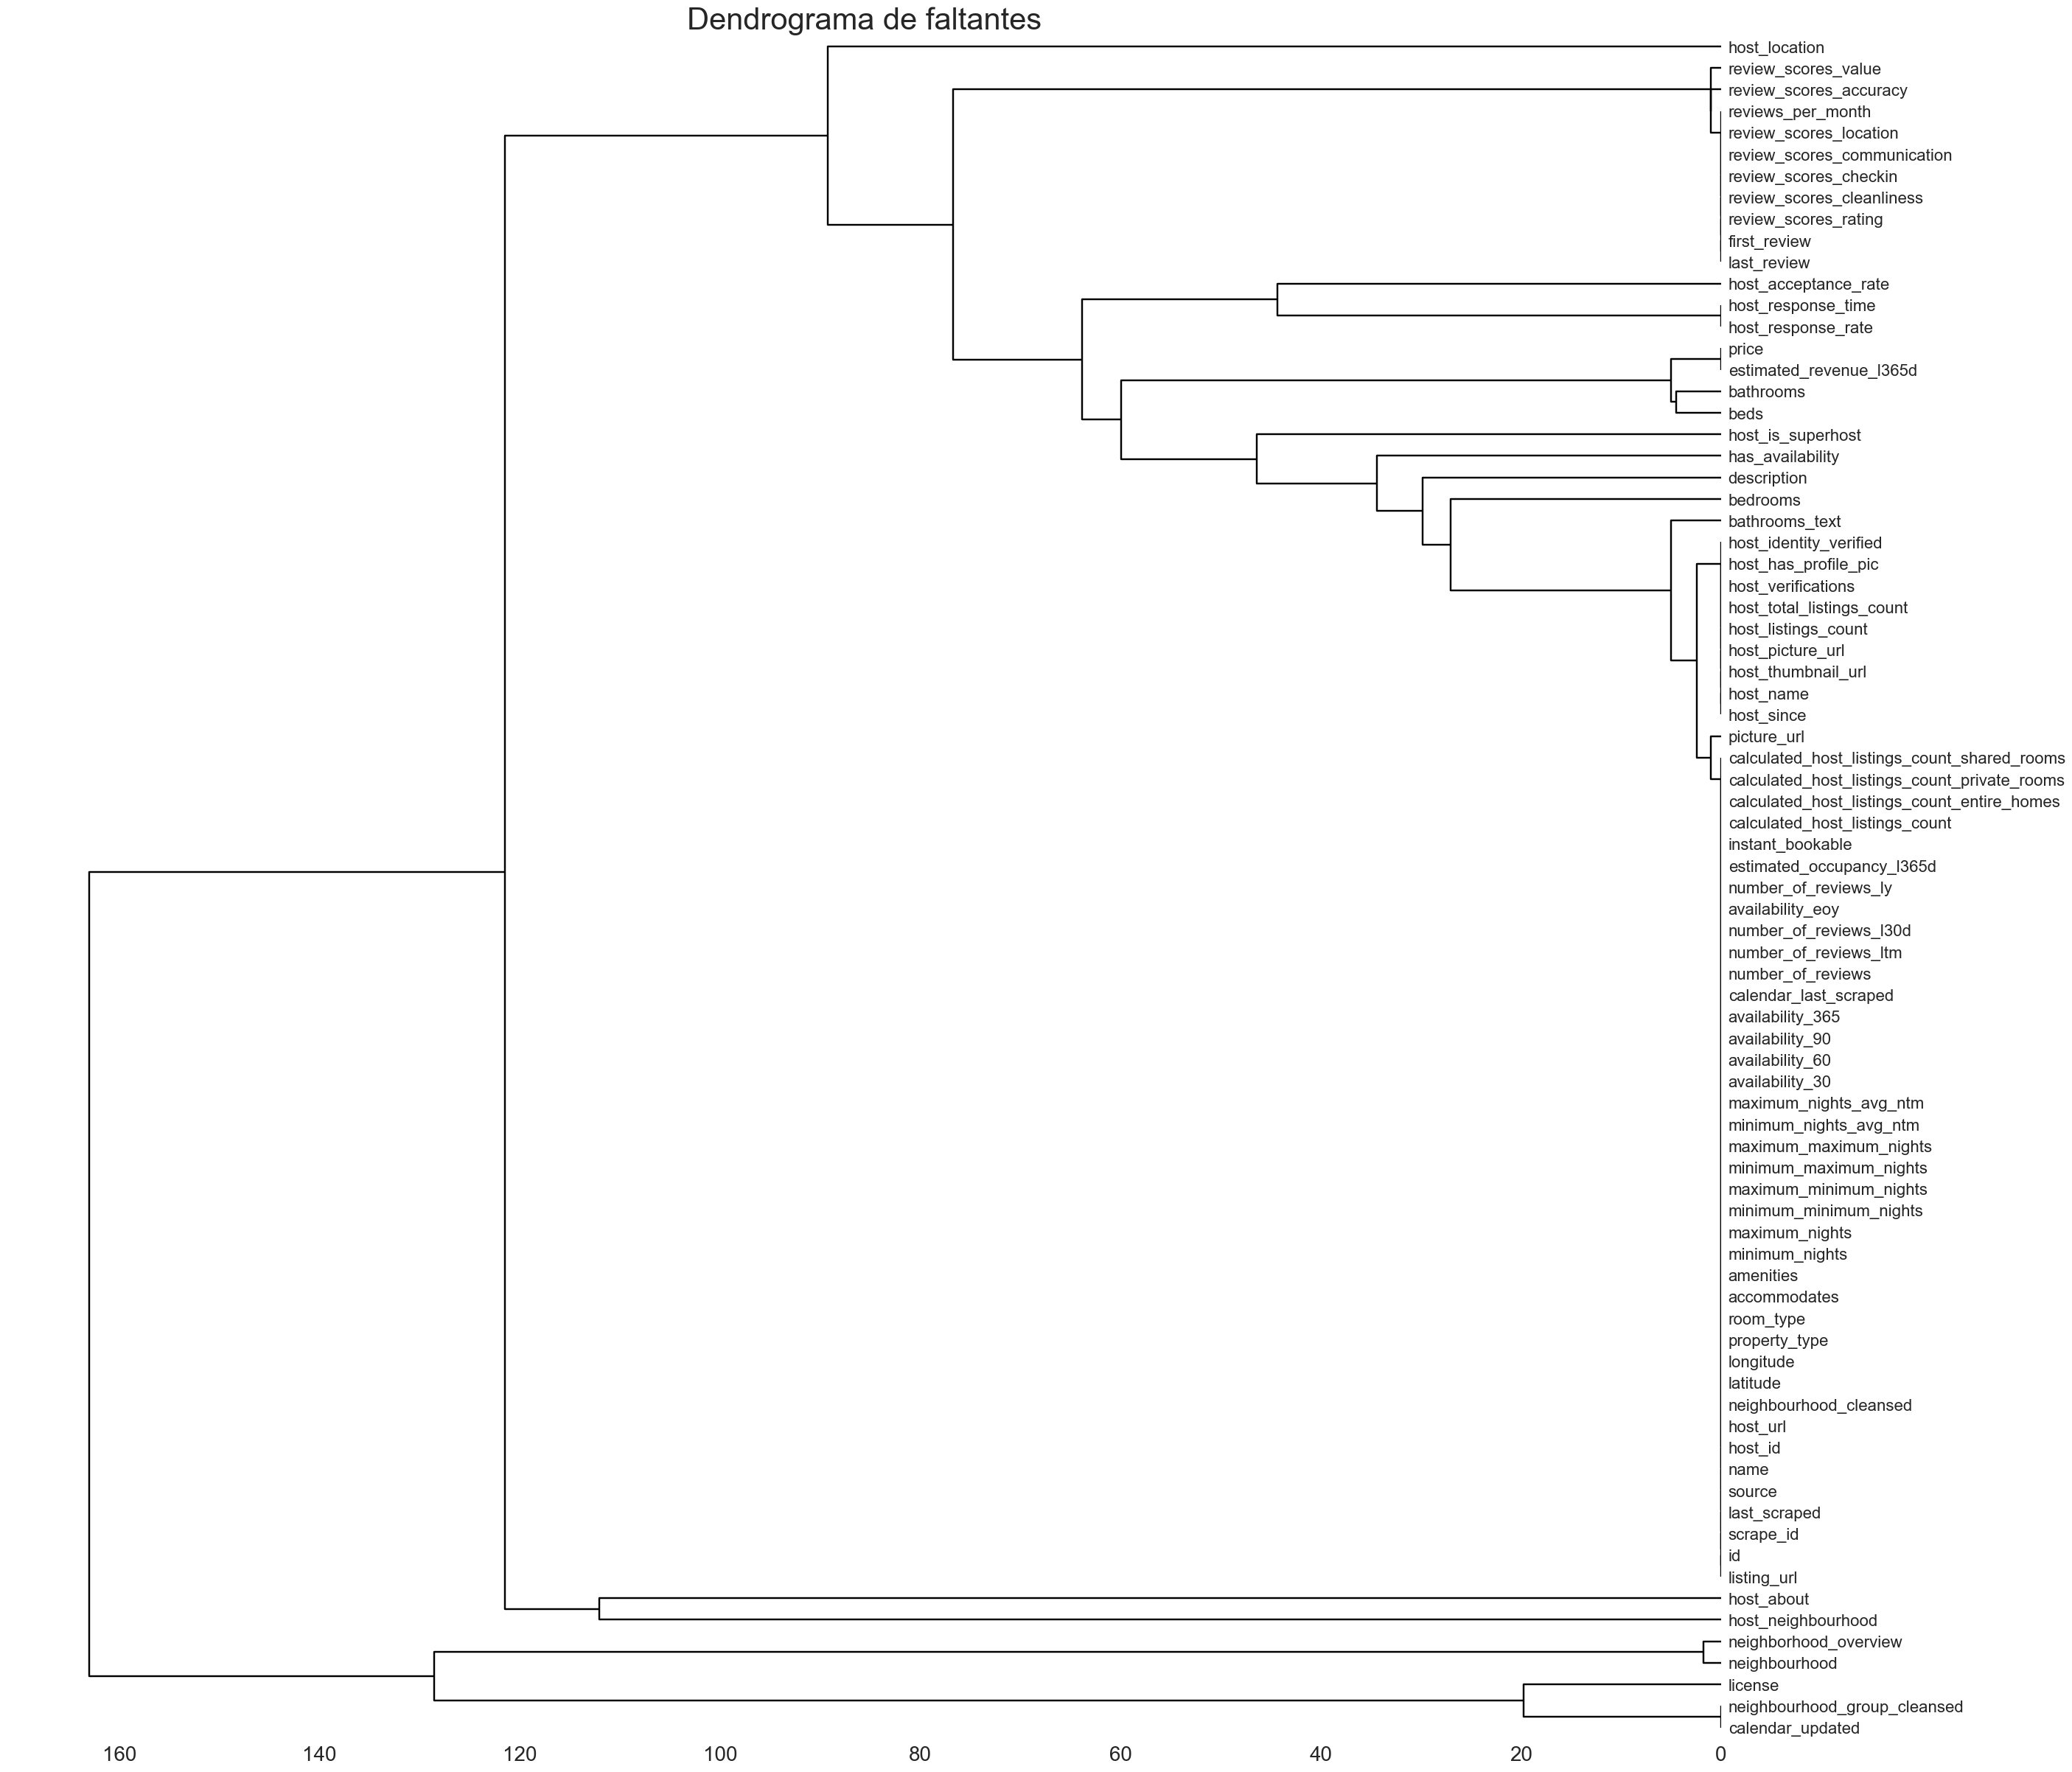

In [554]:
msno.dendrogram(df, figsize=(30,30))
plt.title('Dendrograma de faltantes', fontsize=30)
plt.show()

De aca podemos llegar a la conclusion de que

Las tres columnas con mas nulos son calendar_updated, neighbourhood_group_cleansed y license. Vemos que tienen relacion entre ellas, pero que con el resto de los datos no hay practicamente relacion.


In [555]:
def nulos_por_grupo(df, grupo_cols, target_col):
    agrupar_nulos = (
        df.groupby(grupo_cols, observed=True)[target_col]
        .apply(lambda x: x.isnull().mean() * 100)
        .reset_index(name=f'porcentaje_nulos_{target_col}')
    )
    agrupar_nulos = agrupar_nulos[agrupar_nulos[f'porcentaje_nulos_{target_col}'] != 0.0].sort_values(f'porcentaje_nulos_{target_col}', ascending=False)

    return agrupar_nulos

In [556]:
nulos_precio_por_host = nulos_por_grupo(df, ['room_type','neighbourhood_cleansed'],  'price')
nulos_precio_por_vecindario = nulos_por_grupo(df, 'neighbourhood_cleansed', 'price')
nulos_precio_por_property_type = nulos_por_grupo(df, 'room_type', 'price')
nulos_host_location_por_host = nulos_por_grupo(df, 'has_availability', 'price')

# Resultados:
# print("Nulos en 'price' por host:\n", nulos_precio_por_host, "\n")
# print("Nulos en 'price' por host:\n", nulos_precio_por_host[nulos_precio_por_host['porcentaje_nulos_price']==100], "\n")
# print("Nulos en 'price' por vecindario:\n", nulos_precio_por_vecindario, "\n")
# print("Nulos en 'price' por property type:\n", nulos_precio_por_property_type, "\n")
print("Nulos en 'host_location' por host:\n", nulos_host_location_por_host,"\n")


Nulos en 'host_location' por host:
   has_availability  porcentaje_nulos_price
0                f                 93.8462
1                t                  7.8079 



# 2.0 Split del dataSet en train y test

Tenemos en cuenta de que todos los listing del mismo host no queden divididos


In [557]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(df, groups=df['host_id']))

airbnb_train_df = df.iloc[train_idx].copy()
airbnb_test_df  = df.iloc[test_idx].copy()

# sanity check: no hay host_id compartidos
assert set(airbnb_train_df.host_id) & set(airbnb_test_df.host_id) == set()

print(df.shape, airbnb_test_df.shape, airbnb_train_df.shape)

(35172, 79) (6988, 79) (28184, 79)


In [558]:
# Ejemplo de análisis MAR/MNAR: comparar reviews_per_month faltante vs número de reviews
# reviews_missing_flag = df['reviews_per_month'].isna()
# comparison = df.groupby(reviews_missing_flag)['number_of_reviews'].agg(['mean', 'median', 'count'])
# comparison.index = ['reviews_per_month disponible', 'reviews_per_month faltante']
# comparison

**Interpretación inicial:** La ausencia de `reviews_per_month` suele darse en listados sin reseñas recientes, sugiriendo un mecanismo MAR (dependiente de `number_of_reviews`).


# 2.1 Tratamiento de faltantes


### 2.1.1 Las columnas

- neighbourhood_group_cleansed (100% nulos)
- calendar_updated (100% nulos)
- license (99% nulos)

las eliminamos

In [559]:
airbnb_train_df = airbnb_train_df.drop(columns=['neighbourhood_group_cleansed', 'calendar_updated','license'] )


### 2.1.2 La columna booleanas

- Si has_availability es nula, la completamos con yes si la suma de availability_30, availability_60, availability_90 y availability_365 es distinta de cero y con no si la suma es igual a cero
- Si host_is_superhost no esta definida, significa que puede ser un listing nuevo que aun no fue evaluado por airbnb para ver si califica o no, con lo cual es importante diferenciar de un no. Para eso a los nulos le ponemos no, pero creamos una nueva columna llamada was_evaluated_for_superhost para diferenciarlos de los ya evaluados

In [560]:
cols_sumar = ['availability_30','availability_60', 'availability_90', 'availability_365']

airbnb_train_df.loc[
    (df[cols_sumar].sum(axis=1) != 0) & (df['has_availability'].isna()),
    'has_availability'
] = 't'

airbnb_train_df.loc[
    (airbnb_train_df[cols_sumar].sum(axis=1) == 0) & (airbnb_train_df['has_availability'].isna()),
    'has_availability'
] = 'f'

for col in ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'has_availability']:
    if col in df.columns:
        airbnb_train_df[col] = airbnb_train_df[col].replace({'t': 'yes', 'f': 'no'})

# is_superhost

airbnb_train_df['was_evaluated_for_superhost'] = ~airbnb_train_df['host_is_superhost'].isna()
airbnb_train_df['host_is_superhost'] = airbnb_train_df['host_is_superhost'].map({'t': 'yes', 'f': 'no'}).fillna('no')

print(airbnb_train_df['host_is_superhost'].unique())

print(airbnb_train_df['was_evaluated_for_superhost'].unique())


['no' 'yes']
[ True False]


### 2.1.2 Las columnas neighbourhood (52% nulos), neighbourhood_overview (52% nulos), host_location (46% nulos) y host_about (46% nulos)

- La columna neighbourhood completamos con la del valor codificado neighbourhood_cleansed que es el valor ya codificado de la ubicacion
- La columna neighbourhood_overview le asignamos la clasificacion "not defined"
- La columna host_location y host_about le asignamos la clasificacion "not defined"


In [561]:
airbnb_train_df['neighbourhood'] = airbnb_train_df['neighbourhood'].fillna(airbnb_train_df['neighbourhood_cleansed'])

cols = ['neighborhood_overview', 'host_location', 'host_about','host_neighbourhood']

for col in cols:
    airbnb_train_df[col] = (
        airbnb_train_df[col]
            .astype('string')                         # convierte a string (dtype nativo)
            .replace(r'^\s*$', pd.NA, regex=True)     # "" o espacios → NA
            .fillna('not-defined')                    # completa NA
    )

missing_abs = airbnb_train_df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(airbnb_train_df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct*100})
missing_table[missing_table["missing"]>0].head(79)


,missing,percent
review_scores_accuracy,4725,16.7600
review_scores_value,4725,16.7600
review_scores_checkin,4724,16.7600
reviews_per_month,4724,16.7600
first_review,4724,16.7600
last_review,4724,16.7600
review_scores_rating,4724,16.7600
review_scores_cleanliness,4724,16.7600
review_scores_location,4724,16.7600
review_scores_communication,4724,16.7600


### 2.1.2 Las columnas neighbourhood (52% nulos), neighbourhood_overview (52% nulos), host_location (46% nulos) y host_about (46% nulos)

Podemos observar que el porcentaje de nulos de las columnas asociadas a las reviews es el mismo (16.7%) y coincide con que no hay ni fecha de first_review ni fecha de last_review, esto nos muestra que posiblemente esos listings aun no tengan ninguna review asociada, con lo cual tiene sentido que sean nulos las reviews por aspecto del alojamiento. Lo que vamos a hacer es asignarle un cero pero ademas vamos a crear una nueva columna que indique si el listing tiene reviews o no.

- review_scores_accuracy	    4725	16.7600
- review_scores_value	        4725	16.7600
- reviews_per_month	            4724	16.7600
- first_review	                4724	16.7600
- last_review	                4724	16.7600
- review_scores_rating	        4724	16.7600
- review_scores_location	    4724	16.7600
- review_scores_communication	4724	16.7600
- review_scores_checkin	        4724	16.7600
- review_scores_cleanliness	    4724	16.7600


In [562]:
cols_scores = [
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    'review_scores_value',
    'review_scores_rating'
]

# 1) Definir fecha de referencia para calcular la  cantidad de dias desde la ultima review en base al maximo

reference_date = max(airbnb_train_df['first_review'].max(), airbnb_train_df['last_review'].max())

print("Fecha de referencia:", reference_date)

for c in cols_scores:
    if c in airbnb_train_df.columns:
        airbnb_train_df[c] = pd.to_numeric(airbnb_train_df[c], errors='coerce')

# 2) Flag "tiene reviews"

has_num_reviews = airbnb_train_df['number_of_reviews'] > 0 if 'number_of_reviews' in airbnb_train_df.columns else False
has_first = airbnb_train_df['first_review'].notna() if 'first_review' in airbnb_train_df.columns else False
has_last  = airbnb_train_df['last_review'].notna()  if 'last_review'  in airbnb_train_df.columns else False
has_rpm   = (airbnb_train_df['reviews_per_month'].fillna(0) > 0) if 'reviews_per_month' in airbnb_train_df.columns else False

airbnb_train_df['has_reviews'] = (has_num_reviews | has_first | has_last | has_rpm).astype(bool)

# 3) Poner 0 en scores solo cuando no hay reviews
airbnb_train_df.loc[~airbnb_train_df['has_reviews'], [c for c in cols_scores if c in airbnb_train_df.columns]] = 0

# 3) Crear días desde primera review
airbnb_train_df['days_since_first_review'] = np.where(
    airbnb_train_df['has_reviews'] == 1,
    (reference_date - airbnb_train_df['first_review']).dt.days,
    -1  # -1 indica que no tiene reviews
)

# 4) Crear días desde última review
airbnb_train_df['days_since_last_review'] = np.where(
    airbnb_train_df['has_reviews'] == 1,
    (reference_date - airbnb_train_df['last_review']).dt.days,
    -1
)

if 'reviews_per_month' in airbnb_train_df.columns:
    airbnb_train_df.loc[~airbnb_train_df['has_reviews'] & airbnb_train_df['reviews_per_month'].isna(), 'reviews_per_month'] = 0.0

airbnb_train_df.drop(columns=['first_review', 'last_review'], inplace=True)

missing_abs = airbnb_train_df.isna().sum().sort_values(ascending=False)
missing_pct = (missing_abs / len(airbnb_train_df)).round(4)
missing_table = pd.DataFrame({'missing': missing_abs, 'percent': missing_pct*100})
missing_table[missing_table["missing"]>0].head(79)

Fecha de referencia: 2025-01-30 00:00:00


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,availability_eoy,number_of_reviews_ly,estimated_occupancy_l365d,estimated_revenue_l365d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,was_evaluated_for_superhost,has_reviews,days_since_first_review,days_since_last_review
1,14222,https://www.airbnb.com/rooms/14222,20250129142212,2025-01-30,city scrape,"RELAX IN HAPPY HOUSE - PALERMO, BUENOS AIRES",Beautiful cozy apartment in excellent location...,Palermo is such a perfect place to explore the...,https://a0.muscache.com/pictures/4695637/bbae8...,87710233,https://www.airbnb.com/users/show/87710233,María,2016-08-03,"Buenos Aires, Argentina","Soy Organizadora de Eventos, me gusta relacion...",within an hour,100%,100%,no,https://a0.muscache.com/im/pictures/user/dc9d9...,https://a0.muscache.com/im/pictures/user/dc9d9...,not-defined,7.0000,16.0000,"['email', 'phone']",yes,yes,"Palermo/Buenos Aires, Autonomous City of Bueno...",Palermo,-34.5862,-58.4104,Entire rental unit,Entire home/apt,2,1.0000,1 bath,1.0000,1.0000,"[""Bathtub"", ""Air conditioning"", ""TV"", ""Heating...",22375.0000,7,40,7,7,1125,1125,7.0000,1125.0000,yes,13,43,44,44,2025-01-30,123,8,1,44,8,112,2506000.0000,4.7700,4.7600,4.7700,4.8200,4.9000,4.8700,4.7500,no,6,6,0,0,0.8000,True,True,4587.0000,12.0000
2,15074,https://www.airbnb.com/rooms/15074,20250129142212,2025-01-30,previous scrape,ROOM WITH RIVER SIGHT,NaN,not-defined,https://a0.muscache.com/pictures/91166/c0fdcb4...,59338,https://www.airbnb.com/users/show/59338,Monica,2009-12-02,not-defined,not-defined,NaN,NaN,NaN,no,https://a0.muscache.com/defaults/user_pic-50x5...,https://a0.muscache.com/defaults/user_pic-225x...,not-defined,2.0000,2.0000,[],no,no,Nuñez,Nuñez,-34.5389,-58.4660,Private room in rental unit,Private room,1,NaN,1 bath,NaN,NaN,"[""Washer"", ""Air conditioning"", ""Dryer"", ""TV wi...",NaN,29,730,29,29,730,730,29.0000,730.0000,no,0,0,0,0,2025-01-30,0,0,0,0,0,0,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,no,1,0,1,0,0.0000,True,False,-1.0000,-1.0000
3,16695,https://www.airbnb.com/rooms/16695,20250129142212,2025-01-30,city scrape,DUPLEX LOFT 2 - SAN TELMO,NaN,San Telmo is one of the best neighborhoods in ...,https://a0.muscache.com/pictures/619c33a9-0618...,64880,https://www.airbnb.com/users/show/64880,Elbio Mariano,2009-12-21,"Buenos Aires, Argentina","I was borned in Tucuman, but I live in Buenos ...",within an hour,95%,94%,yes,https://a0.muscache.com/im/pictures/user/bdeda...,https://a0.muscache.com/im/pictures/user/bdeda...,Monserrat,11.0000,13.0000,"['email', 'phone']",yes,yes,"Buenos Aires, Capital Federal, Argentina",Monserrat,-34.6144,-58.3761,Entire loft,Entire home/apt,4,1.0000,1 bath,1.0000,1.0000,"[""Backyard"", ""Air conditioning"", ""Patio or bal...",52511.0000,2,1125,2,2,1125,1125,2.0000,1125.0000,yes,30,60,90,365,2025-01-30,45,0,0,336,0,0,0.0000,4.2800

## 3. Distribuciones y visualizaciones clave


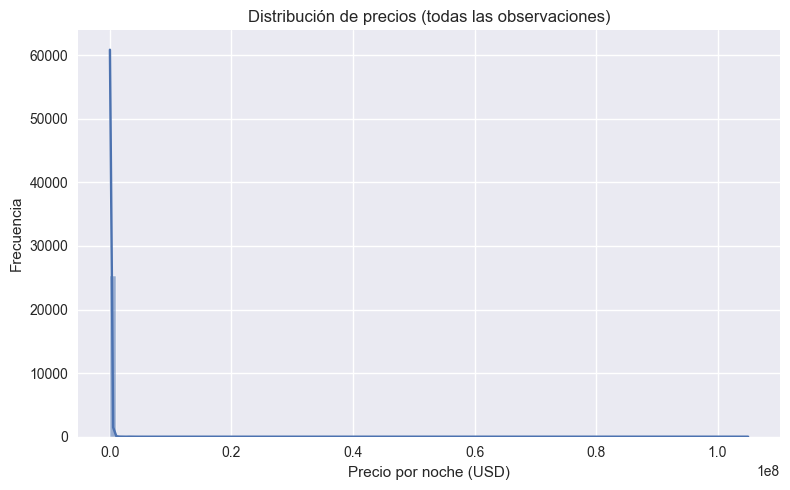

In [563]:
sns.histplot(airbnb_train_df['price'].dropna(), bins=100, kde=True)
plt.title('Distribución de precios (todas las observaciones)')
plt.xlabel('Precio por noche (USD)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


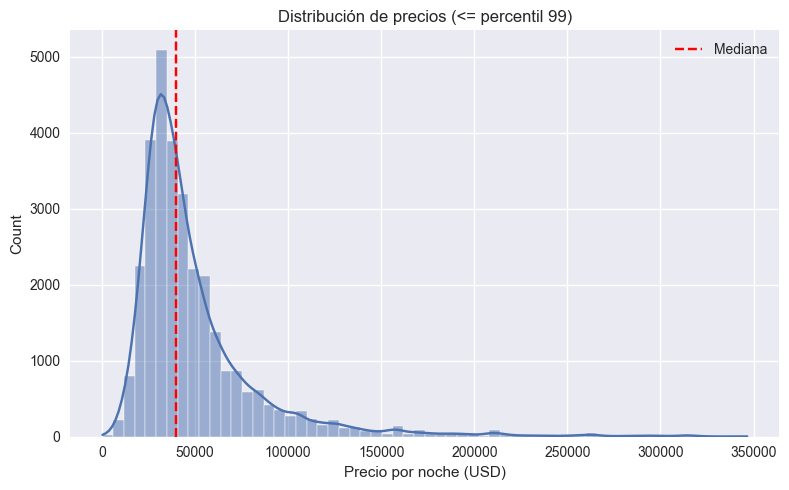

In [564]:
# Distribución recortando el 1% superior para atenuar outliers
price_cap = airbnb_train_df['price'].quantile(0.99)
sns.histplot(df.loc[df['price'] <= price_cap, 'price'], bins=60, kde=True)
plt.axvline(df['price'].median(), color='red', linestyle='--', label='Mediana')
plt.title('Distribución de precios (<= percentil 99)')
plt.xlabel('Precio por noche (USD)')
plt.legend()
plt.tight_layout()
plt.show()


In [565]:
# Skewness de precios para evaluar la asimetría
price_series = airbnb_train_df['price'].dropna()
price_skew = price_series.skew()
positive_prices = price_series[price_series > 0]
price_log_skew = np.log1p(positive_prices).skew() if not positive_prices.empty else np.nan
print(f'Skewness (precio bruto): {price_skew:.3f}')
print(f'Skewness (log1p del precio): {price_log_skew:.3f}')


Skewness (precio bruto): 52.733
Skewness (log1p del precio): 1.780


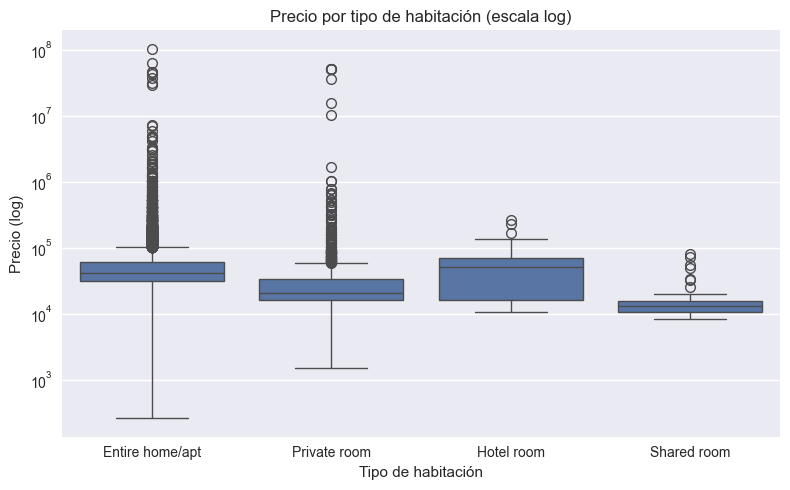

In [566]:
sns.boxplot(data=airbnb_train_df, x='room_type', y='price')
plt.yscale('log')
plt.title('Precio por tipo de habitación (escala log)')
plt.xlabel('Tipo de habitación')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


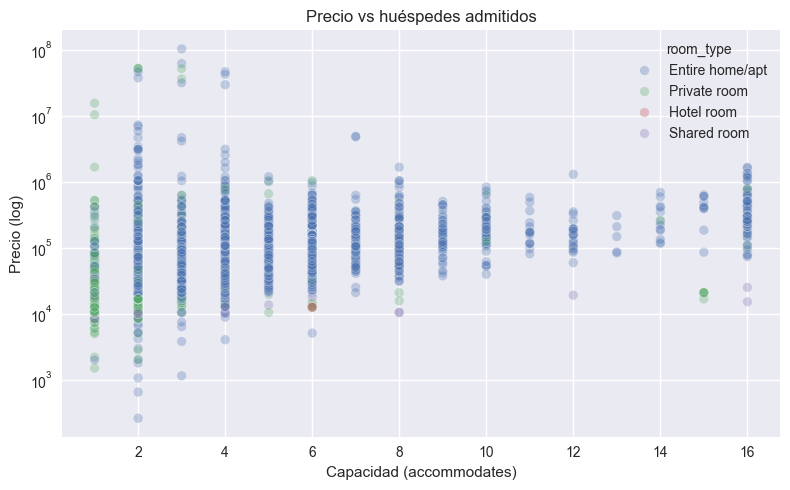

In [567]:
# Precio vs capacidad
sns.scatterplot(data=airbnb_train_df, x='accommodates', y='price', hue='room_type', alpha=0.3)
plt.yscale('log')
plt.title('Precio vs huéspedes admitidos')
plt.xlabel('Capacidad (accommodates)')
plt.ylabel('Precio (log)')
plt.tight_layout()
plt.show()


### Distribuciones de disponibilidad y ocupación


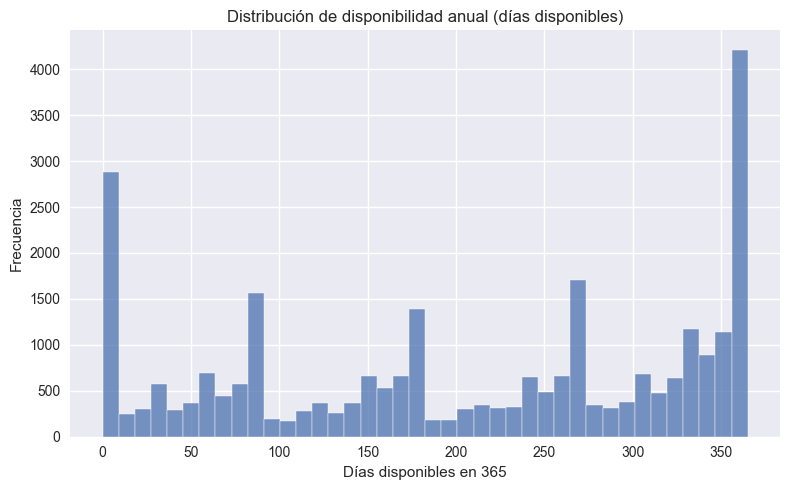

In [568]:
sns.histplot(airbnb_train_df['availability_365'], bins=40, kde=False)
plt.title('Distribución de disponibilidad anual (días disponibles)')
plt.xlabel('Días disponibles en 365')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()


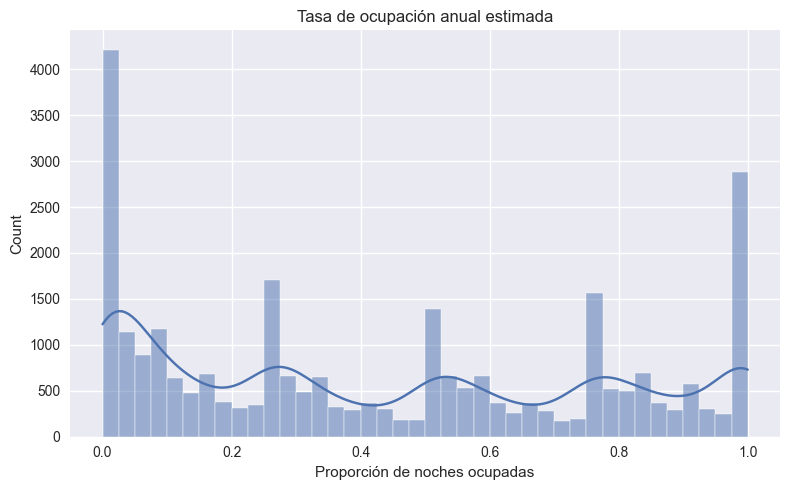

In [569]:
sns.histplot(1 - (airbnb_train_df['availability_365'] / 365), bins=40, kde=True)
plt.title('Tasa de ocupación anual estimada')
plt.xlabel('Proporción de noches ocupadas')
plt.tight_layout()
plt.show()


### Correlación orientada a disponibilidad (categóricas codificadas)
Para estudiar los drivers de disponibilidad aplicamos one-hot encoding sobre las variables categóricas y analizamos la correlación con las tasas de ocupación.


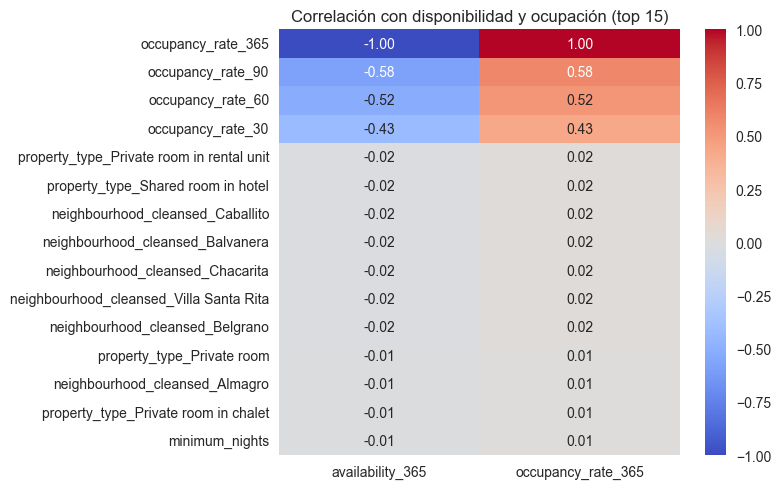

,availability_365,occupancy_rate_365
occupancy_rate_365,-1.0000,1.0000
occupancy_rate_90,-0.5818,0.5818
occupancy_rate_60,-0.5210,0.5210
occupancy_rate_30,-0.4274,0.4274
property_type_Private room in rental unit,-0.0227,0.0227
property_type_Shared room in hotel,-0.0207,0.0207
neighbourhood_cleansed_Caballito,-0.0183,0.0183
neighbourhood_cleansed_Balvanera,-0.0170,0.0170
neighbourhood_cleansed_Chacarita,-0.0167,0.0167
neighbourhood_cleansed_Villa Santa Rita,-0.0162,0.0162


In [570]:
# Codificación de categóricas para matriz de correlación orientada a disponibilidad
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
base_columns = ['accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
                'number_of_reviews', 'reviews_per_month', 'price']

corr_base = airbnb_train_df[base_columns + availability_cols].copy()

for horizon in [30, 60, 90, 365]:
    rate_col = f'occupancy_rate_{horizon}'
    if rate_col not in airbnb_train_df.columns:
        airbnb_train_df[rate_col] = 1 - (airbnb_train_df[f'availability_{horizon}'] / horizon)
    corr_base[rate_col] = airbnb_train_df[rate_col]

binary_map = {'yes': 1, 'no': 0}
for col in ['host_is_superhost', 'instant_bookable']:
    corr_base[f'{col}_flag'] = airbnb_train_df[col].map(binary_map)

categorical_for_corr = ['room_type', 'property_type', 'neighbourhood_cleansed']
corr_encoded = pd.get_dummies(
    pd.concat([corr_base, airbnb_train_df[categorical_for_corr]], axis=1),
    columns=categorical_for_corr,
    drop_first=True
)

corr_matrix = corr_encoded.corr(numeric_only=True)
target_corr = corr_matrix[['availability_365', 'occupancy_rate_365']].sort_values(
    by='occupancy_rate_365', ascending=False
)

top_features = target_corr.head(15).index
sns.heatmap(
    corr_matrix.loc[top_features, ['availability_365', 'occupancy_rate_365']],
    annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1
)
plt.title('Correlación con disponibilidad y ocupación (top 15)')
plt.tight_layout()
plt.show()

target_corr.head(15)


## 4. Disponibilidad y objetivo de ocupación


In [571]:
# Cálculo de tasas de ocupación a partir de la disponibilidad
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
occupancy_df = airbnb_train_df[availability_cols].copy()

for horizon in [30, 60, 90, 365]:
    rate_col = f'occupancy_rate_{horizon}'
    airbnb_train_df[rate_col] = 1 - (airbnb_train_df[f'availability_{horizon}'] / horizon)
    occupancy_df[rate_col] = airbnb_train_df[rate_col]

occupancy_summary = occupancy_df[[f'occupancy_rate_{h}' for h in [30, 60, 90, 365]]].describe().T
print(occupancy_summary[['mean', 'std', 'min', '25%', '50%', '75%', 'max']])

# Target multiclase basado en la tasa anual
bins = [0.0, 0.4, 0.7, 1.01]
labels = ['low', 'mid', 'high']
airbnb_train_df['occupancy_level'] = pd.cut(
    airbnb_train_df['occupancy_rate_365'].clip(lower=0, upper=1),
    bins=bins, labels=labels, right=False, include_lowest=True
)

level_counts = airbnb_train_df['occupancy_level'].value_counts(dropna=False).sort_index()
print('Distribución de occupancy_level:')
print(level_counts)
print('Proporciones:')
print((level_counts / len(airbnb_train_df)).round(3))


                     mean    std    min    25%    50%    75%    max
occupancy_rate_30  0.5103 0.4014 0.0000 0.0667 0.5000 1.0000 1.0000
occupancy_rate_60  0.4463 0.3804 0.0000 0.0500 0.3833 0.8500 1.0000
occupancy_rate_90  0.3941 0.3671 0.0000 0.0444 0.3000 0.6889 1.0000
occupancy_rate_365 0.4360 0.3459 0.0000 0.0904 0.3753 0.7589 1.0000
Distribución de occupancy_level:
occupancy_level
low     14369
mid      5535
high     8280
Name: count, dtype: int64
Proporciones:
occupancy_level
low    0.5100
mid    0.1960
high   0.2940
Name: count, dtype: float64


**Decisión:** Se utilizará la etiqueta multiclase `occupancy_level` para representar la ocupación esperada (low/mid/high). El objetivo del modelado es predecir este nivel sin emplear variables de disponibilidad futuras.


## 5. Planteo del problema supervisado
Planteamos un problema de **clasificación multiclase** donde la variable target es `occupancy_level`, construida a partir de la tasa de ocupación anual estimada. Los niveles son:
- `high`: ocupación >= 70%
- `mid`: ocupación entre 40% y 70%
- `low`: ocupación < 40%

El objetivo es anticipar la categoría de ocupación utilizando únicamente atributos conocidos al momento de publicar un listing (sin recurrir a disponibilidades futuras). Se evaluará con métricas como F1 macro, balanced accuracy y matrices de confusión para garantizar buen desempeño en las tres clases.

Las features consideradas combinan atributos de ubicación (`latitude`, `longitude`, `neighbourhood_cleansed`), configuración (`room_type`, `property_type`, `accommodates`, `bedrooms`), reputación (`number_of_reviews`, `reviews_per_month`, `host_is_superhost`) y métricas derivadas de la actividad del host (`host_tenure_days`, `reviews_per_year`, `days_since_last_review`).


**Definición del target:** `occupancy_level` surge de discretizar la tasa de ocupación anual en tres bandas (`low`, `mid`, `high`) con umbrales (0.0, 0.4, 0.7, 1.0]. Esto permite capturar distintos perfiles de demanda y evita depender de la disponibilidad futura como feature. Registros sin información suficiente quedan con valor nulo y se descartan durante el split de entrenamiento.


## 6. Ingeniería de features y preprocesamiento


### 6.1 Codificación de amenities

Normalizamos la columna JSON de `amenities`, homogenizamos etiquetas y generamos indicadores binarios para las 20 amenidades más frecuentes; estas columnas (`amenity_*`) amplían el set de features con información interpretable.


In [572]:
# Normalizamos la columna de amenities y generamos indicadores binarios
def normalize_amenities(value):
    if pd.isna(value):
        return []
    text = str(value).strip()
    if not text:
        return []
    candidate = text.replace('{', '[').replace('}', ']')
    try:
        parsed = json.loads(candidate)
    except json.JSONDecodeError:
        try:
            parsed = ast.literal_eval(candidate)
        except (ValueError, SyntaxError):
            parsed = [item.strip() for item in candidate.strip('[]').split(',')]
    normalized = []
    for item in parsed:
        token = str(item).strip().strip('"').strip("'")
        if token:
            normalized.append(token.lower())
    return sorted(set(normalized))

amenity_lists = airbnb_train_df['amenities'].apply(normalize_amenities)
amenity_counts = amenity_lists.explode().value_counts()
top_k = 20
top_amenities = amenity_counts.head(top_k)

def amenity_to_col(amenity):
    slug = re.sub(r'[^a-z0-9]+', '_', amenity).strip('_')
    return f'amenity_{slug}' if slug else 'amenity_other'

amenities_feature_cols = []
for amenity in top_amenities.index:
    base_name = amenity_to_col(amenity)
    name = base_name
    suffix = 1
    while name in amenities_feature_cols:
        suffix += 1
        name = f"{base_name}_{suffix}"
    amenities_feature_cols.append(name)
    airbnb_train_df[name] = amenity_lists.apply(lambda items, target=amenity: int(target in items))

top_amenities.to_frame(name='count').assign(percent=lambda data: data['count'] / len(airbnb_train_df))



,count,percent
amenities,,
kitchen,26702,0.9474
wifi,25228,0.8951
hot water,22339,0.7926
dishes and silverware,21941,0.7785
cooking basics,21161,0.7508
hangers,20805,0.7382
essentials,20053,0.7115
bed linens,19905,0.7063
refrigerator,18905,0.6708


In [573]:
# Feature engineering orientado a ocupación
# Imputar reseñas por mes faltantes con 0 (sugiere ausencia de reseñas)
airbnb_train_df['reviews_per_month_filled'] = airbnb_train_df['reviews_per_month'].fillna(0)

# Antigüedad del host y tiempo desde la última reseña
reference_date = airbnb_train_df['last_scraped'].max()
airbnb_train_df['host_tenure_days'] = (reference_date - airbnb_train_df['host_since']).dt.days

airbnb_train_df['days_since_last_review'] = (reference_date - airbnb_train_df['last_review']).dt.days

# Densidad de reseñas: reviews acumulados sobre tenure (evitar división por cero)
airbnb_train_df['reviews_per_year'] = airbnb_train_df['number_of_reviews'] / (airbnb_train_df['host_tenure_days'] / 365)
airbnb_train_df.loc[airbnb_train_df['host_tenure_days'] <= 0, 'reviews_per_year'] = np.nan

# Construimos dataset sin columnas de disponibilidad para evitar fuga de información
amenities_feature_cols = globals().get('amenities_feature_cols', [])
base_feature_cols = [
    'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'price_imputed',
    'number_of_reviews', 'reviews_per_month_filled', 'latitude', 'longitude',
    'host_is_superhost', 'instant_bookable', 'room_type', 'property_type',
    'neighbourhood_cleansed', 'host_tenure_days', 'days_since_last_review', 'reviews_per_year'
]

feature_cols = base_feature_cols + amenities_feature_cols

model_df = airbnb_train_df[feature_cols + ['occupancy_level']].copy()
model_df.head()



KeyError: 'last_review'

In [134]:
target_col = 'occupancy_level'
X = model_df.drop(columns=[target_col])
y = model_df[target_col]

print(f'Observaciones totales para modelado: {len(X)}')
print(f'Registros sin target: {y.isna().sum()} (serán descartados antes del split)')


NameError: name 'model_df' is not defined

In [538]:
from sklearn.model_selection import train_test_split

valid_rows = y.notna()
X_valid = X.loc[valid_rows]
y_valid = y.loc[valid_rows]

X_train, X_test, y_train, y_test = train_test_split(
    X_valid, y_valid, test_size=0.2, random_state=42
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


NameError: name 'y' is not defined

In [539]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

amenities_feature_cols = globals().get('amenities_feature_cols', [])

numeric_features = [
    'accommodates', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights',
    'number_of_reviews', 'reviews_per_month_filled', 'latitude', 'longitude',
    'host_tenure_days', 'days_since_last_review', 'reviews_per_year'
]

numeric_features += amenities_feature_cols

price_feature = ['price_imputed']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

price_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_features = [
    'host_is_superhost', 'instant_bookable', 'room_type', 'property_type', 'neighbourhood_cleansed'
]

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('price', price_transformer, price_feature),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

print(f'Matriz transformada - train: {X_train_prepared.shape}')
print(f'Matriz transformada - test: {X_test_prepared.shape}')



NameError: name 'X_train' is not defined

### Balance del target (low/mid/high)


In [ ]:
y_train.value_counts(normalize=True).sort_index()


## 7. Selección y reducción de dimensionalidad


In [ ]:
# Importancia de features numéricas (ANOVA F-score)
from sklearn.feature_selection import f_classif

numeric_matrix = preprocessor.named_transformers_['num'].transform(X_train[numeric_features])
f_scores, p_values = f_classif(numeric_matrix, y_train)

anova_scores = (pd.Series(f_scores, index=numeric_features)
                  .sort_values(ascending=False))
anova_scores


In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

numeric_matrix = preprocessor.named_transformers_['num'].transform(X_train[numeric_features])
selector = SelectKBest(score_func=mutual_info_classif, k=min(8, len(numeric_features)))
selector.fit(numeric_matrix, y_train)

selected_numeric = [numeric_features[i] for i in selector.get_support(indices=True)]
print('Mejores features numéricas según mutual information:', selected_numeric)


In [ ]:
from sklearn.decomposition import PCA

# Aplicamos PCA sobre features numéricas estandarizadas
numeric_imputed = preprocessor.named_transformers_['num'].fit_transform(X_train[numeric_features])
pca = PCA().fit(numeric_imputed)
explained_variance = pd.DataFrame({
    'componente': np.arange(1, len(pca.explained_variance_ratio_) + 1),
    'var_ratio': pca.explained_variance_ratio_,
    'var_acumulada': np.cumsum(pca.explained_variance_ratio_)
})
explained_variance.head(10)


In [ ]:
plt.plot(explained_variance['componente'], explained_variance['var_acumulada'], marker='o')
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('Curva de varianza explicada por PCA')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**Interpretación:** Con ~6 componentes se retiene alrededor del 80% de la varianza numérica, útil si se necesita compactar el espacio antes de entrenar clasificadores sensibles a la dimensionalidad (p. ej. regresión logística).


## 8. Próximos pasos sugeridos
- Entrenar clasificadores multiclase (`LogisticRegression`, `RandomForestClassifier`, `XGBoost`) usando el pipeline de `preprocessor`.
- Medir F1 macro, balanced accuracy y analizar la matriz de confusión para los niveles `low/mid/high`.
- Ajustar umbrales o reglas de decisión según la estrategia comercial (p. ej. priorizar recall de `high`).
- Incorporar nuevas variables disponibles al crear el anuncio (amenities, políticas, texto) para mejorar el poder predictivo sin depender de disponibilidad futura.


- Entrenar un modelo base (p. ej. `RandomForestRegressor`, `GradientBoostingRegressor`) usando el pipeline de `preprocessor`.
- Validar con una métrica robusta (MAE) y comparar contra un baseline como la mediana.
- Explorar ingeniería específica del vecindario (densidad de listings, precio medio por zona) y disponibilidad.
- Evaluar estrategias de tuning (GridSearch/Optuna) y monitoreo de drift con `wandb`.
